## Get ground truth from active model

In [1]:
from neuron import h
import pandas as pd
import numpy as np
from templates.active_model_synapse_input import *

mechanisms_path = 'mechanisms'  # need to compile the folder first
geometry_file = 'geom_standard.csv'
tstop = 20. # ms
dt = 0.025  # ms. does not allow change

h.nrn_load_dll(os.path.join(mechanisms_path,'nrnmech.dll'))  # running this line more than once might crash the kernel
#h.nrn_load_dll(os.path.join(mechanisms_path,'x86_64/.libs/libnrnmech.so'))  # use this line instead in Linux
geo_standard = pd.read_csv(geometry_file,index_col='id')
h.tstop = tstop
h.dt = dt

In [2]:
x = np.zeros(96)
y = np.linspace(-1900,1900,96)
z = np.zeros(96)
elec_pos = np.column_stack((x,y,z))

In [3]:
loc_param = [80,350,3.0,0.9,1.27]
sim = Simulation(geo_standard,elec_pos,loc_param,gmax=0.0025,scale=10000.)

In [4]:
sim.run()
lfp = sim.get_lfp().T

In [ ]:
from scipy import signal

filt_b,filt_a = signal.butter(2,100,'hp',fs=40000) # order 2, 100 Hz, highpass, sampling rate = 40kHz
lfp = signal.lfilter(filt_b,filt_a,lfp,axis=0)

In [6]:
import h5py

hf = h5py.File('active_groundtruth.h5', 'w')
hf.create_dataset('data',data=lfp)
hf.close()

## Setup simulation of passive model

In [ ]:
from neuron import h
import pandas as pd
import numpy as np
from templates.passive_model_soma_injection import *

geometry_file = 'geom_standard.csv'
tstop = 20.  # ms
dt = 0.025  # ms. does not allow change

geo_standard = pd.read_csv(geometry_file,index_col='id')
h.tstop = tstop
h.dt = dt

make default electrode coordinates

In [28]:
x = np.zeros(96)
y = np.linspace(-1900,1900,96)
z = np.zeros(96)
elec_pos = np.column_stack((x,y,z))

Load ground truth data

In [17]:
import h5py

hf = h5py.File('active_groundtruth.h5', 'r')
groundtruth_lfp = np.array(hf.get('data'))
hf.close()

In [27]:
start_idx = 360
window_size = 96
maxIndx = np.argmax(np.absolute(groundtruth_lfp).max(axis=0))  # find maximum absolute value from averaged traces
maxTrace = -groundtruth_lfp[start_idx:,maxIndx]
x0_trace = groundtruth_lfp[start_idx:start_idx+window_size,:]
soma_injection = np.insert(maxTrace,0,0.)

Create simulation

In [ ]:
sim = Simulation(geo_standard,elec_pos,soma_injection)
sim.run()
t = sim.t()
t0 = t[:window_size]

## Setup inference model

In [1]:
import matplotlib.pyplot as plt
import math
import torch
from sbi.inference import SNPE, prepare_for_sbi
from sbi.utils.get_nn_models import posterior_nn
import sbi.utils as utils

In [34]:
from scipy import signal
from utils.spike_window import first_pk_tr, get_spike_window

filt_b,filt_a = signal.butter(2,100,'hp',fs=40000) # order 2, 100 Hz, highpass, sampling rate = 40kHz
fst_idx = first_pk_tr(x0_trace) # get first peak/trough location

def model(param,whole_trace=False):
    sim.set_loc_param(param[:5])
    scalVal = 10 ** param[5]
    sim.set_scale(scalVal)
    sim.create_cells()
    sim.run()
    lfp = sim.get_lfp().T
    filtered_lfp = signal.lfilter(filt_b,filt_a,lfp,axis=0) # filter along row of the lfp 2d-array, if each row is a channel
    if not whole_trace:
        start,end = get_spike_window(filtered_lfp,win_size=window_size,align_at=fst_idx)
        filtered_lfp = filtered_lfp[start:end,:]
#     simDict = {"traces": filtered_lfp,"time": t}
    return filtered_lfp

In [ ]:
from scipy import stats as spstats

y_dist = elec_pos[:,1].ravel()

def Stats(lfp):
    """
    Calculates summary statistics
    results = model(params)
    """
    lfp = np.asarray(lfp)
    
    avg = np.mean(lfp,axis=0) # average voltage of each channel
#     stdDev = np.std(lfp,axis=0) # stDev of the voltage of each channel
    tT = np.argmin(lfp,axis=0)
    tP = np.argmax(lfp,axis=0)
    Troughs = np.take_along_axis(lfp,np.expand_dims(tT,axis=0),axis=0)
    Peaks = np.take_along_axis(lfp,np.expand_dims(tP,axis=0),axis=0)
    relT = tP-tT
    stats_list = [avg,Troughs,Peaks,relT]
    
    def statscalc(stats):
        stats = stats.ravel()
        mean = np.mean(stats)
        std = np.std(stats)
        m = np.argmin(stats)
        min_pos = y_dist[m]
        min_val = stats[m]
        M = np.argmax(stats)
        max_pos = y_dist[M] 
        max_val = stats[M]
        All = np.array([mean,std,min_pos,min_val,max_pos,max_val])
        return All
    
    allStats = np.concatenate([statscalc(x) for x in stats_list])
    return allStats

In [36]:
import torch

def cat_output(lfp):
    stats = Stats(lfp)
    output = np.concatenate(lfp.ravel(),stats)
    return torch.from_numpy(output)

def simulation(params):
    lfp = model(params)
    return cat_output(lfp)

In [37]:
import torch.nn as nn
import torch.nn.functional as F

nelec = y_dist.size
nout = window_size*nelec

class SummaryNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 96x96 -> 96x96
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, padding=1, padding_mode='replicate')
        # 96x96 -> 48x48
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        # 48x48 -> 48x48
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=5, kernel_size=3, padding=1, padding_mode='replicate')
        # 48x48 -> 24x24
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        # 24x24 -> 24x24
        self.conv3 = nn.Conv2d(in_channels=5, out_channels=5, kernel_size=3, padding=1, padding_mode='replicate')
        # 24x24 -> 12x12
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        # 12x12 -> 10x10
        self.conv4 = nn.Conv2d(in_channels=5, out_channels=5, kernel_size=3)
        # 10x10 -> 5x5
        self.pool4 = nn.MaxPool2d(kernel_size=2)
        # Fully connected layer taking as input the 8 flattened output arrays from the maxpooling layer
        self.fc = nn.Linear(in_features=125, out_features=12) # 5*5*5=125

    def forward(self,x):
        x0 = x[:,nout:]
        x = x[:,:nout]
        x = x.view(-1,1,window_size,nelec) # (batch size,in_channels,height,length) -1 means not changing size of that dimension
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))
        x = x.view(-1,125) # (batch size, in_features)
        x = F.relu(self.fc(x))
        x = torch.cat((x,x0),dim=1)
        return x

embedding_net = SummaryNet()

Lower/upper bounds

In [ ]:
bounds = [[10,200],[-2000,2000],[0,np.pi],[-1,1],[0,np.pi],[4,5]]
Lows = torch.tensor([b[0] for b in bounds], dtype=float)
Highs = torch.tensor([b[1] for b in bounds], dtype=float)
# prior.sample() #example sample

In [39]:
simulator, prior = prepare_for_sbi(simulation, prior)

In [45]:
# instantiate the neural density estimator
neural_posterior = utils.posterior_nn(model='maf', 
                                      embedding_net=embedding_net,
                                      hidden_features=10)

In [46]:
# setup the inference procedure with the SNPE-C procedure
from sbi import inference
inference = inference.SNPE(simulator, prior, 
                           density_estimator=neural_posterior,
                           sample_with_mcmc=True,
                           show_progress_bars=True,
                          show_round_summary=True)

In [ ]:
# 2 rounds: first round simulates from the prior, second round simulates from the obtained posterior.
num_rounds = 3
num_simulations = 5000
x_o = cat_output(x0_trace)

In [ ]:
posteriors = []
proposal = None
for _ in range(num_rounds):
    posterior = inference(num_simulations=5000,proposal=proposal)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)

In [ ]:
samples = posterior.sample((1000,), x=x_o) #,sample_with_mcmc=True)

(array([  4.,   5.,   4.,  22.,  42.,  76., 126., 222., 308., 191.]),
 array([-33.125813, -32.293953, -31.462093, -30.630234, -29.798374,
        -28.966515, -28.134657, -27.302797, -26.470938, -25.639078,
        -24.807219], dtype=float32),
 <a list of 10 Patch objects>)

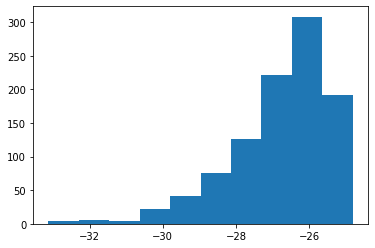

In [286]:
#posterior.leakage_correction(x_o, num_rejection_samples=1000)
log_probability = posterior.log_prob(samples,x=x_o) #, norm_posterior=False
# plt.hist(log_probability)

In [283]:
sample_idx = np.argmax(log_probability)
predicted_post = samples[sample_idx]
predicted_post

tensor([6.4880e+01, 3.8765e+01, 4.1398e-01, 5.7322e-01, 3.4641e+00, 4.5317e+00,
        3.6776e+02, 1.6011e-01])

a


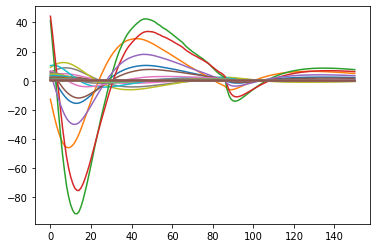

In [262]:
from utils.plot_results import plot_LFP_traces,plot_LFP_heatmap

predicted_lfp = model(predicted_post,whole_trace=True)
start,end = get_spike_window(predicted_lfp,win_size=window_size,align_at=fst_idx)
predicted_lfp_win = filtered_lfp[start:end,:]
fig,ax = plot_LFP_traces(t0,predicted_lfp_win)
fig,ax = plot_LFP_heatmap(t0,predicted_lfp_win)
print(start)

In [ ]:
fig,ax = plot_LFP_traces(t0,x0_trace)
fig,ax = plot_LFP_heatmap(t0,x0_trace)

In [ ]:
from utils.plot_results import corrcoef, max_corrcoef

max_corr, max_ind = max_corrcoef(x0_trace,predicted_lfp)
print(max_corr,max_ind)

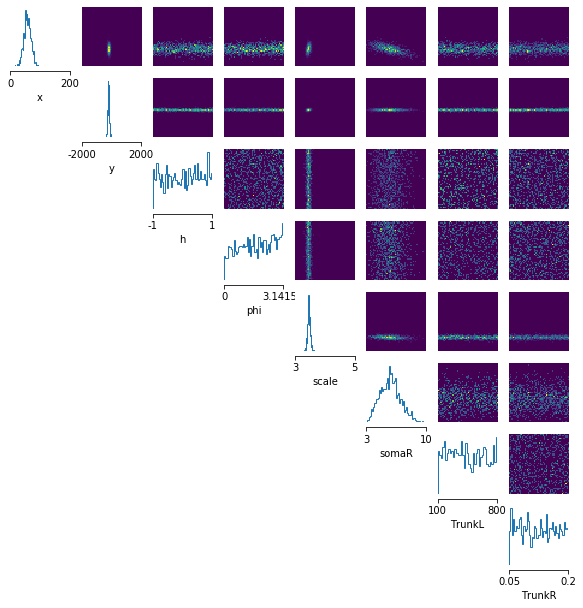

In [285]:
labels_params = [ r'x',r'y',r'$\theta$',r'h',r'$\phi$',r'$\lambda$']
fig, axes = utils.pairplot(samples,
                           limits = bounds
                           ticks = bounds
                           fig_size=(12,12),
                           #points=true_params,
                           points_offdiag={'markersize': 6},
                           labels = labels_params,
                           points_colors='r');

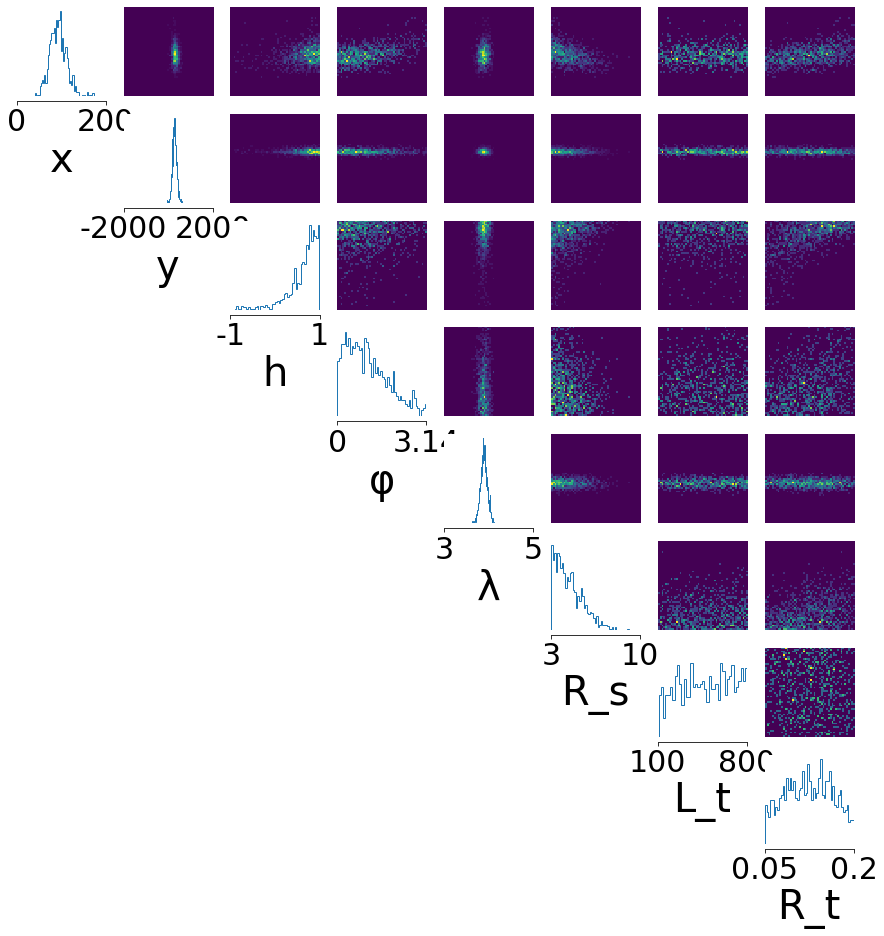

In [99]:
%matplotlib inline

labels_params = [ r'x',r'y',r'$\theta$',r'h',r'$\phi$',r'$\lambda$']
fig, axes = utils.pairplot(samples,
                           limits = bounds
                           ticks = bounds
                           fig_size=(15,15),
                           #points=true_params,
                           points_offdiag={'markersize': 6},
                           labels = labels_params,
                           points_colors='r');

FS = 40
# axes[0][0].set_xlabel('x',fontsize = FS,zorder=2.5)
# axes[1][1].set_xlabel('y',fontsize = FS,zorder=2.5)
# axes[2][2].set_xlabel('h',fontsize = FS,zorder=2.5)
# axes[3][3].set_xlabel('\u03C6',fontsize=FS )
# axes[4][4].set_xlabel('\u03BB',fontsize = FS)
for i in range(8):
    axes[i][i].tick_params('x',labelsize=15,zorder=2.5)
    axes[i][i].labelsize = 40

for i,b in enumerate(bounds):
    axes[i][i].set_xticklabels([str(b[0]),str(b[1])],fontsize=30)

# plt.savefig('/home/ddopp4877/Desktop/cell360_GEO_KDE.pdf', bbox_inches='tight',transparent=True)